# Translation Quality Testing for Human Rights Scenarios

This notebook tests the quality of translations for human rights scenarios to identify potential artifacts that might cause models to respond differently across languages. We'll perform back-translation tests (English → Chinese → English and English → Romanian → English) and analyze semantic similarity between original and back-translated texts.

## Objectives:
1. Test translation fidelity for scenario prompts
2. Identify translation artifacts that might bias model responses
3. Quantify semantic drift between original and back-translated texts
4. Recommend improvements to the translation pipeline

## 1. Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import asyncio
import time
import os
from typing import List, Dict, Tuple, Any
import warnings
from collections import defaultdict
import re

# Translation libraries
from googletrans import Translator
from dotenv import load_dotenv
from tqdm.asyncio import tqdm

# Text similarity libraries - using Hugging Face instead of NLTK
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import difflib

# Hugging Face libraries for text processing and metrics
from transformers import AutoTokenizer
import evaluate  # Hugging Face evaluate library
from datasets import Dataset

# Load environment variables
load_dotenv(override=True)

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully!")
print("📊 Setting up translation quality testing environment with Hugging Face implementations...")
print("🤗 Using Hugging Face evaluate library for BLEU and ROUGE metrics")

✅ All libraries imported successfully!
📊 Setting up translation quality testing environment with Hugging Face implementations...
🤗 Using Hugging Face evaluate library for BLEU and ROUGE metrics


## 2. Load Scenario Data

Load the multilingual scenarios dataset and extract English prompts for testing. We'll select a representative sample of scenarios across different rights and conditions.

In [2]:
# File paths
MULTILINGUAL_PATH = "data/scenarios/scenarios_single_right_multilingual.csv"
EVALUATED_PATH = "data/scenarios/scenarios_single_right_evaluated.csv"

# Load data - try multilingual first, fall back to evaluated scenarios if not available
try:
    if os.path.exists(MULTILINGUAL_PATH):
        print(f"📂 Loading multilingual scenarios from {MULTILINGUAL_PATH}")
        multilingual_df = pd.read_csv(MULTILINGUAL_PATH)
        # Extract English scenarios
        english_scenarios = multilingual_df[multilingual_df['lang_code'] == 'en'].copy()
        print(f"   Found {len(english_scenarios)} English scenarios")
    else:
        print(f"📂 Multilingual file not found. Loading evaluated scenarios from {EVALUATED_PATH}")
        english_scenarios = pd.read_csv(EVALUATED_PATH)
        print(f"   Found {len(english_scenarios)} evaluated scenarios")

    print(f"📊 Dataset info:")
    print(f"   - Total scenarios: {len(english_scenarios)}")
    print(f"   - Rights covered: {english_scenarios['limited_article'].nunique()}")
    print(f"   - Columns: {list(english_scenarios.columns)}")

except FileNotFoundError as e:
    print(f"❌ Error: Could not find scenario data files.")
    print(f"   Please run create_scenarios.py first to generate the scenarios.")
    print(f"   Expected files: {MULTILINGUAL_PATH} or {EVALUATED_PATH}")
    raise e

# Select all scenarios for testing instead of sampling
print(f"\n🎯 Using all scenarios for comprehensive translation testing...")

# Select all scenarios for testing instead of sampling
print(f"\n🎯 Using all scenarios for comprehensive translation testing...")

test_scenarios = english_scenarios.copy().reset_index(drop=True)

print(f"✅ Using all {len(test_scenarios)} scenarios for testing:")
print(f"   - Rights: {sorted(test_scenarios['limited_article'].unique())}")
print(f"   - Severity levels: {sorted(test_scenarios['severity'].unique())}")
print(f"   - Emergency states: {sorted(test_scenarios['state_of_emergency'].unique())}")

# Show sample scenarios
print(f"\n📝 Sample scenarios:")
for i, row in test_scenarios.head(3).iterrows():
    rights_name = row.get('limited_article_name', f"Article {row['limited_article']}")
    emergency = row['state_of_emergency'].replace('_', ' ').title() if row['state_of_emergency'] != 'no' else 'Normal'

    # Use scenario_text if available, otherwise construct from available fields
    if 'scenario_text' in row and pd.notna(row['scenario_text']):
        scenario_text = row['scenario_text'][:100] + "..."
    elif 'scenario_prompt_likert' in row and pd.notna(row['scenario_prompt_likert']):
        # Extract scenario from likert prompt if available
        scenario_text = row['scenario_prompt_likert'].split('\n\n')[0][:100] + "..."
    else:
        scenario_text = f"Scenario for {rights_name}"

    print(f"   {i+1}. {rights_name} (Severity {row['severity']}, {emergency})")
    print(f"      {scenario_text}")
    print()

📂 Loading multilingual scenarios from data/scenarios/scenarios_single_right_multilingual.csv
   Found 144 English scenarios
📊 Dataset info:
   - Total scenarios: 144
   - Rights covered: 24
   - Columns: ['limited_article', 'limited_article_name', 'limited_right_text', 'actor', 'severity', 'state_of_emergency', 'affected_group', 'scenario_text', 'plausibility', 'clarity', 'justification', 'neutrality', 'severity_score', 'primarily_limited', 'substantially_limited', 'moderately_limited', 'somewhat_limited', 'somewhat_promoted', 'moderately_promoted', 'substantially_promoted', 'primarily_promoted', 'lang_code', 'scenario_prompt_likert', 'scenario_prompt_open', 'system_prompt_likert', 'system_prompt_open']

🎯 Using all scenarios for comprehensive translation testing...

🎯 Using all scenarios for comprehensive translation testing...
✅ Using all 144 scenarios for testing:
   - Rights: [np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), 

## 3. Set Up Translation Functions

Create functions for forward translation (English to target language) and back translation (target language back to English) using Google Translate API with error handling and rate limiting.

In [4]:
class TranslationTester:
    """Handle translation testing with error handling, rate limiting, and batch processing."""

    def __init__(self, delay: float = 0.2):
        self.translator = Translator()
        self.delay = delay  # Delay between translations to avoid rate limiting
        self.failed_translations = []

    async def translate_text(self, text: str, target_lang: str, max_retries: int = 3) -> str:
        """Translate text to target language with retries."""
        for attempt in range(max_retries):
            try:
                # Add delay to respect rate limits
                await asyncio.sleep(self.delay)

                # Perform translation
                result = await self.translator.translate(text, dest=target_lang)
                return result.text

            except Exception as e:
                if attempt < max_retries - 1:
                    await asyncio.sleep(1)  # Wait longer before retry
                else:
                    self.failed_translations.append({
                        'text': text[:50] + "...",
                        'target_lang': target_lang,
                        'error': str(e)
                    })
                    return text  # Return original text if all attempts fail

    async def translate_batch(self, texts: List[str], target_lang: str, batch_size: int = 15) -> List[str]:
        """Translate a batch of texts with controlled concurrency and progress tracking."""
        translated = []

        # Process in smaller batches to avoid overwhelming the API
        with tqdm(total=len(texts), desc=f"Translating to {target_lang}", unit="texts") as pbar:
            for i in range(0, len(texts), batch_size):
                batch = texts[i:i + batch_size]
                batch_tasks = [self.translate_text(text, target_lang) for text in batch]
                batch_results = await asyncio.gather(*batch_tasks, return_exceptions=True)

                # Handle any exceptions in the batch
                for j, result in enumerate(batch_results):
                    if isinstance(result, Exception):
                        translated.append(batch[j])  # Use original text
                    else:
                        translated.append(result)

                # Update progress bar
                pbar.update(len(batch))

        return translated

    async def back_translate(self, text: str, intermediate_lang: str) -> Tuple[str, str]:
        """
        Perform back translation: English -> intermediate_lang -> English
        Returns: (intermediate_translation, back_translation)
        """
        # Forward translation: English -> intermediate language
        intermediate = await self.translate_text(text, intermediate_lang)

        # Back translation: intermediate language -> English
        back_translated = await self.translate_text(intermediate, 'en')

        return intermediate, back_translated

    async def back_translate_batch(self, texts: List[str], intermediate_lang: str, batch_size: int = 15) -> Tuple[List[str], List[str]]:
        """
        Perform batch back translation: English -> intermediate_lang -> English
        Returns: (intermediate_translations, back_translations)
        """
        print(f"🔄 Processing {intermediate_lang} batch translation pipeline...")

        # First batch: English -> intermediate language
        print(f"   Step 1: English → {intermediate_lang}")
        intermediate_translations = await self.translate_batch(texts, intermediate_lang, batch_size)

        # Second batch: intermediate language -> English
        print(f"   Step 2: {intermediate_lang} → English")
        back_translations = await self.translate_batch(intermediate_translations, 'en', batch_size)

        return intermediate_translations, back_translations

    async def test_translation_pipeline(self, texts: List[str], target_languages: List[str]) -> Dict[str, Any]:
        """Test translation pipeline for multiple texts and languages using batch processing."""
        results = {
            'original_texts': texts,
            'translations': {},
            'back_translations': {},
            'intermediate_translations': {}
        }

        for lang in target_languages:
            intermediate_translations, back_translations = await self.back_translate_batch(texts, lang)

            results['translations'][lang] = back_translations
            results['back_translations'][lang] = back_translations
            results['intermediate_translations'][lang] = intermediate_translations

            print(f"   ✅ Completed {lang} pipeline")

        return results

# Initialize translation tester
translator_tester = TranslationTester(delay=0.1)

# Define target languages for testing
TARGET_LANGUAGES = {
    'zh-cn': 'Chinese (Simplified)',
    'ro': 'Romanian',
    'ar': 'Arabic',
    'ru': 'Russian',
    'hi': 'Hindi',
    'zu': 'Zulu',
    'es': 'Spanish'
}

print(f"🌐 Translation tester initialized")
print(f"📋 Testing languages: {list(TARGET_LANGUAGES.values())}")
print(f"⏱️  Rate limiting: {translator_tester.delay}s delay between translations")

🌐 Translation tester initialized
📋 Testing languages: ['Chinese (Simplified)', 'Romanian', 'Arabic', 'Russian', 'Hindi', 'Zulu', 'Spanish']
⏱️  Rate limiting: 0.1s delay between translations


## 4. Perform Forward and Back Translation

Execute the translation pipeline: English → Chinese → English and English → Romanian → English for the selected scenarios. Store intermediate translations for analysis.

In [5]:
# Extract texts to translate - try different text sources
def extract_test_texts(scenarios_df: pd.DataFrame) -> List[str]:
    """Extract scenario texts for translation testing."""

    # Priority order of columns to use for text extraction
    text_columns = ['scenario_text', 'scenario_prompt_likert', 'scenario_prompt_open']

    texts = []
    sources = []

    for _, row in scenarios_df.iterrows():
        text_found = False

        for col in text_columns:
            if col in row and pd.notna(row[col]) and str(row[col]).strip():
                text = str(row[col]).strip()

                # For prompt columns, extract just the scenario part
                if 'prompt' in col and 'Given this context' in text:
                    # Extract text before "Given this context"
                    scenario_part = text.split('Given this context')[0].strip()
                    if scenario_part:
                        texts.append(scenario_part)
                        sources.append(col)
                        text_found = True
                        break
                else:
                    texts.append(text)
                    sources.append(col)
                    text_found = True
                    break

        if not text_found:
            # Fallback: create a simple description
            rights_name = row.get('limited_article_name', f"Article {row['limited_article']}")
            fallback_text = f"A scenario involving restrictions on {rights_name} with severity level {row['severity']}."
            texts.append(fallback_text)
            sources.append('generated')

    return texts, sources

# Extract test texts
test_texts, text_sources = extract_test_texts(test_scenarios)

print(f"📝 Extracted {len(test_texts)} texts for translation testing")
print(f"📊 Text sources: {dict(pd.Series(text_sources).value_counts())}")

# Show sample texts
print(f"\n🔍 Sample texts to translate:")
for i in range(min(3, len(test_texts))):
    print(f"\n{i+1}. Source: {text_sources[i]}")
    print(f"   Text: {test_texts[i][:200]}{'...' if len(test_texts[i]) > 200 else ''}")

# Perform translation testing
print(f"\n🚀 Starting translation pipeline testing...")
print(f"   This may take several minutes due to rate limiting...")

# Run the translation pipeline
translation_results = await translator_tester.test_translation_pipeline(
    test_texts,
    list(TARGET_LANGUAGES.keys())
)

print(f"\n✅ Translation pipeline completed!")

# Report any translation failures
if translator_tester.failed_translations:
    print(f"\n⚠️  Translation failures: {len(translator_tester.failed_translations)}")
    for failure in translator_tester.failed_translations[:3]:
        print(f"   • {failure['target_lang']}: {failure['text']} - {failure['error']}")
else:
    print(f"🎉 All translations completed successfully!")

# Show sample results
print(f"\n📊 Translation Results Summary:")
for lang_code, lang_name in TARGET_LANGUAGES.items():
    original_count = len(translation_results['original_texts'])
    translated_count = len(translation_results['back_translations'][lang_code])
    print(f"   {lang_name}: {translated_count}/{original_count} texts processed")

# Create results DataFrame for easier analysis
results_data = []
for i, original_text in enumerate(translation_results['original_texts']):
    row_data = {
        'index': i,
        'original_text': original_text,
        'text_source': text_sources[i],
        'limited_article': test_scenarios.iloc[i]['limited_article'],
        'limited_article_name': test_scenarios.iloc[i].get('limited_article_name', ''),
        'severity': test_scenarios.iloc[i]['severity'],
        'state_of_emergency': test_scenarios.iloc[i]['state_of_emergency']
    }

    # Add translation results for each language
    for lang_code, lang_name in TARGET_LANGUAGES.items():
        row_data[f'{lang_code}_intermediate'] = translation_results['intermediate_translations'][lang_code][i]
        row_data[f'{lang_code}_back_translation'] = translation_results['back_translations'][lang_code][i]

    results_data.append(row_data)

translation_df = pd.DataFrame(results_data)

print(f"\n📈 Created translation results DataFrame with {len(translation_df)} rows and {len(translation_df.columns)} columns")
print(f"🔤 Columns: {list(translation_df.columns)}")

# Show a sample of the results
print(f"\n🔍 Sample translation results:")
for i in range(min(2, len(translation_df))):
    row = translation_df.iloc[i]
    print(f"\nScenario {i+1} - {row['limited_article_name']}:")
    print(f"   Original: {row['original_text'][:100]}...")

    for lang_code, lang_name in TARGET_LANGUAGES.items():
        intermediate = row[f'{lang_code}_intermediate']
        back_trans = row[f'{lang_code}_back_translation']
        print(f"   {lang_name} intermediate: {intermediate[:100]}...")
        print(f"   {lang_name} back-translation: {back_trans[:100]}...")
    print()

📝 Extracted 144 texts for translation testing
📊 Text sources: {'scenario_text': np.int64(144)}

🔍 Sample texts to translate:

1. Source: scenario_text
   Text: The government introduces a mandatory national service program requiring people to participate in community improvement projects for a period of three months after completing their education, with the...

2. Source: scenario_text
   Text: The government introduces a mandatory national service program requiring people to work in designated sectors such as agriculture, infrastructure repair, and elder care for indefinite periods without ...

3. Source: scenario_text
   Text: Following a devastating hurricane that has left much of the region’s infrastructure in ruins, the government issues an emergency order requiring people to participate in mandatory community clean-up s...

🚀 Starting translation pipeline testing...
   This may take several minutes due to rate limiting...
🔄 Processing zh-cn batch translation pipeline...
   Step 

Translating to zh-cn: 100%|██████████| 144/144 [00:18<00:00,  7.63texts/s]


   Step 2: zh-cn → English


Translating to en: 100%|██████████| 144/144 [00:13<00:00, 10.59texts/s]


   ✅ Completed zh-cn pipeline
🔄 Processing ro batch translation pipeline...
   Step 1: English → ro


Translating to ro: 100%|██████████| 144/144 [00:15<00:00,  9.39texts/s]


   Step 2: ro → English


Translating to en: 100%|██████████| 144/144 [00:15<00:00,  9.23texts/s]


   ✅ Completed ro pipeline
🔄 Processing ar batch translation pipeline...
   Step 1: English → ar


Translating to ar: 100%|██████████| 144/144 [00:10<00:00, 13.71texts/s]


   Step 2: ar → English


Translating to en: 100%|██████████| 144/144 [00:13<00:00, 10.36texts/s]


   ✅ Completed ar pipeline
🔄 Processing ru batch translation pipeline...
   Step 1: English → ru


Translating to ru: 100%|██████████| 144/144 [00:09<00:00, 14.51texts/s]


   Step 2: ru → English


Translating to en: 100%|██████████| 144/144 [00:10<00:00, 13.71texts/s]


   ✅ Completed ru pipeline
🔄 Processing hi batch translation pipeline...
   Step 1: English → hi


Translating to hi: 100%|██████████| 144/144 [00:15<00:00,  9.57texts/s]


   Step 2: hi → English


Translating to en: 100%|██████████| 144/144 [00:17<00:00,  8.37texts/s]


   ✅ Completed hi pipeline
🔄 Processing zu batch translation pipeline...
   Step 1: English → zu


Translating to zu: 100%|██████████| 144/144 [00:15<00:00,  9.49texts/s]


   Step 2: zu → English


Translating to en: 100%|██████████| 144/144 [00:13<00:00, 10.83texts/s]


   ✅ Completed zu pipeline
🔄 Processing es batch translation pipeline...
   Step 1: English → es


Translating to es: 100%|██████████| 144/144 [00:11<00:00, 12.14texts/s]


   Step 2: es → English


Translating to en: 100%|██████████| 144/144 [00:11<00:00, 12.45texts/s]

   ✅ Completed es pipeline

✅ Translation pipeline completed!
🎉 All translations completed successfully!

📊 Translation Results Summary:
   Chinese (Simplified): 144/144 texts processed
   Romanian: 144/144 texts processed
   Arabic: 144/144 texts processed
   Russian: 144/144 texts processed
   Hindi: 144/144 texts processed
   Zulu: 144/144 texts processed
   Spanish: 144/144 texts processed

📈 Created translation results DataFrame with 144 rows and 21 columns
🔤 Columns: ['index', 'original_text', 'text_source', 'limited_article', 'limited_article_name', 'severity', 'state_of_emergency', 'zh-cn_intermediate', 'zh-cn_back_translation', 'ro_intermediate', 'ro_back_translation', 'ar_intermediate', 'ar_back_translation', 'ru_intermediate', 'ru_back_translation', 'hi_intermediate', 'hi_back_translation', 'zu_intermediate', 'zu_back_translation', 'es_intermediate', 'es_back_translation']

🔍 Sample translation results:

Scenario 1 - Freedom from Slavery:
   Original: The government introduc

## 5. Calculate Text Similarity Metrics

Compute multiple similarity metrics between original and back-translated texts including BLEU score, semantic similarity using sentence transformers, and lexical similarity measures.

In [6]:
class SimilarityCalculator:
    """Calculate various similarity metrics between original and back-translated texts using Hugging Face."""

    def __init__(self):
        print("🤖 Loading sentence transformer model...")
        self.sentence_model = SentenceTransformer('all-MiniLM-L6-v2')
        print("✅ Sentence transformer loaded")

        print("🤗 Loading Hugging Face tokenizer and metrics...")
        # Load a fast tokenizer for word tokenization
        self.tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

        # Load Hugging Face evaluation metrics
        self.bleu_metric = evaluate.load('bleu')
        self.rouge_metric = evaluate.load('rouge')

        print("✅ Hugging Face metrics loaded (BLEU, ROUGE)")

    def calculate_bleu_score(self, original: str, back_translated: str) -> float:
        """Calculate BLEU score using Hugging Face evaluate library."""
        try:
            # Tokenize using Hugging Face tokenizer
            original_tokens = self.tokenizer.tokenize(original.lower())
            back_translated_tokens = self.tokenizer.tokenize(back_translated.lower())

            # Convert tokens back to words (remove ## prefixes from subwords)
            original_words = [token.replace('##', '') for token in original_tokens if not token.startswith('[')]
            back_translated_words = [token.replace('##', '') for token in back_translated_tokens if not token.startswith('[')]

            # Join tokens back to strings for Hugging Face evaluate
            original_text = ' '.join(original_words)
            back_translated_text = ' '.join(back_translated_words)

            # Calculate BLEU score
            bleu_result = self.bleu_metric.compute(
                predictions=[back_translated_text],
                references=[[original_text]]
            )
            return float(bleu_result['bleu'])

        except Exception as e:
            print(f"⚠️  BLEU calculation error: {e}")
            return 0.0

    def calculate_rouge_score(self, original: str, back_translated: str) -> Dict[str, float]:
        """Calculate ROUGE scores using Hugging Face evaluate library."""
        try:
            rouge_result = self.rouge_metric.compute(
                predictions=[back_translated],
                references=[original]
            )
            return {
                'rouge1': float(rouge_result['rouge1']),
                'rouge2': float(rouge_result['rouge2']),
                'rougeL': float(rouge_result['rougeL'])
            }
        except Exception as e:
            print(f"⚠️  ROUGE calculation error: {e}")
            return {'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0}

    def calculate_semantic_similarity(self, original: str, back_translated: str) -> float:
        """Calculate semantic similarity using sentence transformers."""
        try:
            # Get embeddings
            embeddings = self.sentence_model.encode([original, back_translated])

            # Calculate cosine similarity
            similarity = cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]
            return float(similarity)
        except Exception as e:
            print(f"⚠️  Semantic similarity calculation error: {e}")
            return 0.0

    def calculate_tfidf_similarity(self, original: str, back_translated: str) -> float:
        """Calculate TF-IDF based cosine similarity."""
        try:
            # Create TF-IDF vectors
            vectorizer = TfidfVectorizer(stop_words='english', lowercase=True)
            tfidf_matrix = vectorizer.fit_transform([original, back_translated])

            # Calculate cosine similarity
            similarity = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]
            return float(similarity)
        except Exception as e:
            print(f"⚠️  TF-IDF similarity calculation error: {e}")
            return 0.0

    def calculate_character_similarity(self, original: str, back_translated: str) -> float:
        """Calculate character-level similarity using difflib."""
        try:
            similarity = difflib.SequenceMatcher(None, original, back_translated).ratio()
            return float(similarity)
        except Exception as e:
            print(f"⚠️  Character similarity calculation error: {e}")
            return 0.0

    def calculate_word_overlap(self, original: str, back_translated: str) -> float:
        """Calculate word overlap ratio using Hugging Face tokenizer."""
        try:
            # Tokenize using Hugging Face tokenizer
            original_tokens = set(self.tokenizer.tokenize(original.lower()))
            back_translated_tokens = set(self.tokenizer.tokenize(back_translated.lower()))

            # Remove special tokens
            original_tokens = {token for token in original_tokens if not token.startswith('[')}
            back_translated_tokens = {token for token in back_translated_tokens if not token.startswith('[')}

            if len(original_tokens) == 0:
                return 0.0

            overlap = len(original_tokens.intersection(back_translated_tokens))
            return overlap / len(original_tokens)
        except Exception as e:
            print(f"⚠️  Word overlap calculation error: {e}")
            return 0.0

    def calculate_length_ratio(self, original: str, back_translated: str) -> float:
        """Calculate length ratio (back_translated / original)."""
        try:
            if len(original) == 0:
                return 0.0
            return len(back_translated) / len(original)
        except Exception as e:
            print(f"⚠️  Length ratio calculation error: {e}")
            return 0.0

    def calculate_all_similarities(self, original: str, back_translated: str) -> Dict[str, float]:
        """Calculate all similarity metrics including ROUGE scores."""
        rouge_scores = self.calculate_rouge_score(original, back_translated)

        base_metrics = {
            'bleu_score': self.calculate_bleu_score(original, back_translated),
            'semantic_similarity': self.calculate_semantic_similarity(original, back_translated),
            'tfidf_similarity': self.calculate_tfidf_similarity(original, back_translated),
            'character_similarity': self.calculate_character_similarity(original, back_translated),
            'word_overlap': self.calculate_word_overlap(original, back_translated),
            'length_ratio': self.calculate_length_ratio(original, back_translated)
        }

        # Combine base metrics with ROUGE scores
        return {**base_metrics, **rouge_scores}

# Initialize similarity calculator
similarity_calc = SimilarityCalculator()

# Calculate similarity metrics for all translations
print(f"📊 Calculating similarity metrics for all translations...")

similarity_results = []

with tqdm(total=len(translation_df), desc="Calculating similarities", unit="scenarios") as pbar:
    for i, row in translation_df.iterrows():
        original_text = row['original_text']

        row_results = {
            'index': i,
            'original_text': original_text,
            'limited_article': row['limited_article'],
            'limited_article_name': row['limited_article_name'],
            'severity': row['severity'],
            'state_of_emergency': row['state_of_emergency']
        }

        # Calculate similarities for each language
        for lang_code, lang_name in TARGET_LANGUAGES.items():
            back_translated = row[f'{lang_code}_back_translation']

            similarities = similarity_calc.calculate_all_similarities(original_text, back_translated)

            # Add language-specific similarity metrics
            for metric_name, value in similarities.items():
                row_results[f'{lang_code}_{metric_name}'] = value

        similarity_results.append(row_results)
        pbar.update(1)

# Create similarity DataFrame
similarity_df = pd.DataFrame(similarity_results)

print(f"✅ Calculated similarity metrics for {len(similarity_df)} scenarios")
print(f"📊 Metrics per language: {list(similarities.keys())}")

# Show summary statistics
print(f"\n📈 Similarity Metrics Summary (including ROUGE scores):")
metric_columns = [col for col in similarity_df.columns if any(lang in col for lang in TARGET_LANGUAGES.keys())]

for lang_code, lang_name in TARGET_LANGUAGES.items():
    print(f"\n{lang_name} ({lang_code}):")
    lang_metrics = [col for col in metric_columns if col.startswith(f'{lang_code}_')]

    for metric_col in lang_metrics:
        metric_name = metric_col.replace(f'{lang_code}_', '').replace('_', ' ').title()
        mean_val = similarity_df[metric_col].mean()
        std_val = similarity_df[metric_col].std()
        min_val = similarity_df[metric_col].min()
        max_val = similarity_df[metric_col].max()

        print(f"   {metric_name:<20}: {mean_val:.3f} ± {std_val:.3f} (range: {min_val:.3f} - {max_val:.3f})")

# Identify scenarios with low similarity scores (potential translation issues)
print(f"\n🚨 Scenarios with Potential Translation Issues:")
threshold = 0.7  # Semantic similarity threshold

for lang_code, lang_name in TARGET_LANGUAGES.items():
    sem_sim_col = f'{lang_code}_semantic_similarity'
    low_similarity = similarity_df[similarity_df[sem_sim_col] < threshold]

    print(f"\n{lang_name} - Scenarios with semantic similarity < {threshold}:")
    if len(low_similarity) > 0:
        for _, row in low_similarity.iterrows():
            print(f"   • {row['limited_article_name']} (Article {row['limited_article']}): {row[sem_sim_col]:.3f}")
    else:
        print(f"   ✅ All scenarios above threshold!")

print(f"\n💾 Similarity analysis completed with Hugging Face metrics!")

🤖 Loading sentence transformer model...
✅ Sentence transformer loaded
🤗 Loading Hugging Face tokenizer and metrics...
✅ Hugging Face metrics loaded (BLEU, ROUGE)
📊 Calculating similarity metrics for all translations...


Calculating similarities: 100%|██████████| 144/144 [01:10<00:00,  2.04scenarios/s]

✅ Calculated similarity metrics for 144 scenarios
📊 Metrics per language: ['bleu_score', 'semantic_similarity', 'tfidf_similarity', 'character_similarity', 'word_overlap', 'length_ratio', 'rouge1', 'rouge2', 'rougeL']

📈 Similarity Metrics Summary (including ROUGE scores):

Chinese (Simplified) (zh-cn):
   Bleu Score          : 0.472 ± 0.075 (range: 0.273 - 0.636)
   Semantic Similarity : 0.952 ± 0.022 (range: 0.838 - 0.984)
   Tfidf Similarity    : 0.637 ± 0.067 (range: 0.449 - 0.778)
   Character Similarity: 0.208 ± 0.145 (range: 0.007 - 0.639)
   Word Overlap        : 0.729 ± 0.052 (range: 0.594 - 0.830)
   Length Ratio        : 0.954 ± 0.039 (range: 0.855 - 1.057)
   Rouge1              : 0.763 ± 0.039 (range: 0.664 - 0.843)
   Rouge2              : 0.536 ± 0.069 (range: 0.377 - 0.689)
   Rougel              : 0.706 ± 0.056 (range: 0.552 - 0.824)

Romanian (ro):
   Bleu Score          : 0.549 ± 0.071 (range: 0.328 - 0.805)
   Semantic Similarity : 0.942 ± 0.029 (range: 0.814 - 0.98

## 6. Analyze Translation Quality

Analyze translation quality by scenario type, identify patterns in translation artifacts, and flag scenarios with significant semantic drift that might affect model responses.

In [7]:
# Analyze translation quality patterns
print("🔍 Analyzing Translation Quality Patterns (with Hugging Face Metrics)")
print("=" * 60)

# 1. Compare metrics between languages (including ROUGE scores)
print("\n1. Language Comparison:")
metric_names = ['semantic_similarity', 'bleu_score', 'rouge1', 'rouge2', 'rougeL',
                'tfidf_similarity', 'character_similarity', 'word_overlap']

comparison_data = []
for lang_code, lang_name in TARGET_LANGUAGES.items():
    for metric in metric_names:
        col_name = f'{lang_code}_{metric}'
        if col_name in similarity_df.columns:
            comparison_data.append({
                'language': lang_name,
                'language_code': lang_code,
                'metric': metric.replace('_', ' ').title(),
                'mean_score': similarity_df[col_name].mean(),
                'std_score': similarity_df[col_name].std(),
                'min_score': similarity_df[col_name].min(),
                'max_score': similarity_df[col_name].max()
            })

comparison_df = pd.DataFrame(comparison_data)

# Show comparison table
for metric in metric_names:
    metric_title = metric.replace('_', ' ').title()
    print(f"\n📊 {metric_title}:")
    metric_data = comparison_df[comparison_df['metric'] == metric_title]
    for _, row in metric_data.iterrows():
        print(f"   {row['language']:<20}: {row['mean_score']:.3f} ± {row['std_score']:.3f}")

# 2. Analyze by scenario characteristics
print(f"\n2. Translation Quality by Scenario Characteristics:")

# Group by rights category if available
if 'limited_article' in similarity_df.columns:
    print(f"\n📋 By Human Rights Article:")

    for lang_code, lang_name in TARGET_LANGUAGES.items():
        print(f"\n{lang_name}:")
        semantic_col = f'{lang_code}_semantic_similarity'

        article_stats = similarity_df.groupby('limited_article')[semantic_col].agg(['mean', 'std', 'count']).round(3)
        article_stats = article_stats.sort_values('mean', ascending=False)

        print(f"   {'Article':<8} {'Mean':<8} {'Std':<8} {'Count':<6} {'Name'}")
        print(f"   {'-'*8} {'-'*8} {'-'*8} {'-'*6} {'-'*20}")

        for article_num, stats in article_stats.iterrows():
            article_name = similarity_df[similarity_df['limited_article'] == article_num]['limited_article_name'].iloc[0]
            article_name = article_name[:20] + "..." if len(article_name) > 20 else article_name
            print(f"   {article_num:<8} {stats['mean']:<8.3f} {stats['std']:<8.3f} {stats['count']:<6.0f} {article_name}")

# Group by severity and emergency state
print(f"\n📊 By Scenario Conditions:")
for lang_code, lang_name in TARGET_LANGUAGES.items():
    print(f"\n{lang_name}:")
    semantic_col = f'{lang_code}_semantic_similarity'

    condition_stats = similarity_df.groupby(['severity', 'state_of_emergency'])[semantic_col].agg(['mean', 'std', 'count']).round(3)

    print(f"   {'Severity':<8} {'Emergency':<15} {'Mean':<8} {'Std':<8} {'Count'}")
    print(f"   {'-'*8} {'-'*15} {'-'*8} {'-'*8} {'-'*5}")

    for (severity, emergency), stats in condition_stats.iterrows():
        emergency_text = emergency.replace('_', ' ').title() if emergency != 'no' else 'Normal'
        print(f"   {severity:<8} {emergency_text:<15} {stats['mean']:<8.3f} {stats['std']:<8.3f} {stats['count']:<5.0f}")

# 3. Identify problematic patterns (updated with ROUGE metrics)
print(f"\n3. 🚨 Problematic Translation Patterns:")

# Find scenarios with significant differences between metrics
problem_threshold = {
    'semantic_similarity': 0.7,
    'bleu_score': 0.3,
    'rouge1': 0.4,
    'rouge2': 0.2,
    'rougeL': 0.4,
    'word_overlap': 0.5
}

problematic_scenarios = []

for lang_code, lang_name in TARGET_LANGUAGES.items():
    print(f"\n{lang_name} Issues:")
    lang_problems = []

    for metric, threshold in problem_threshold.items():
        col_name = f'{lang_code}_{metric}'
        if col_name in similarity_df.columns:
            low_scores = similarity_df[similarity_df[col_name] < threshold]

            if len(low_scores) > 0:
                print(f"   📉 Low {metric.replace('_', ' ').title()} (< {threshold}):")
                for _, row in low_scores.iterrows():
                    problem_info = {
                        'language': lang_name,
                        'language_code': lang_code,
                        'metric': metric,
                        'score': row[col_name],
                        'threshold': threshold,
                        'article': row['limited_article'],
                        'article_name': row['limited_article_name'],
                        'scenario_index': row['index']
                    }
                    lang_problems.append(problem_info)
                    print(f"      • Article {row['limited_article']} ({row['limited_article_name']}): {row[col_name]:.3f}")
            else:
                print(f"   ✅ All scenarios pass {metric.replace('_', ' ').title()} threshold ({threshold})")

    problematic_scenarios.extend(lang_problems)

# 4. Detailed examination of worst cases (including ROUGE scores)
print(f"\n4. 🔬 Detailed Analysis of Worst Translation Cases:")

for lang_code, lang_name in TARGET_LANGUAGES.items():
    semantic_col = f'{lang_code}_semantic_similarity'
    worst_cases = similarity_df.nsmallest(3, semantic_col)

    print(f"\n{lang_name} - Worst 3 cases by semantic similarity:")

    for i, (_, row) in enumerate(worst_cases.iterrows()):
        print(f"\n   Case {i+1}: Article {row['limited_article']} - {row['limited_article_name']}")
        print(f"   Semantic Similarity: {row[semantic_col]:.3f}")

        # Get the original and back-translated texts
        original_idx = row['index']
        original_text = translation_df.iloc[original_idx]['original_text']
        back_translated = translation_df.iloc[original_idx][f'{lang_code}_back_translation']
        intermediate = translation_df.iloc[original_idx][f'{lang_code}_intermediate']

        print(f"   Original: {original_text[:150]}...")
        print(f"   {lang_name}: {intermediate[:150]}...")
        print(f"   Back-translated: {back_translated[:150]}...")

        # Show other metrics for this case (including ROUGE)
        other_metrics = ['bleu_score', 'rouge1', 'rouge2', 'rougeL', 'tfidf_similarity', 'word_overlap']
        metric_values = []
        for metric in other_metrics:
            col_name = f'{lang_code}_{metric}'
            if col_name in similarity_df.columns:
                metric_values.append(f"{metric.replace('_', ' ').title()}: {row[col_name]:.3f}")
        print(f"   Other metrics: {', '.join(metric_values)}")

# 5. Generate recommendations (updated for Hugging Face metrics)
print(f"\n5. 💡 Translation Quality Recommendations (Hugging Face Enhanced):")

overall_recommendations = []
language_specific_recommendations = {}

# Overall analysis
avg_semantic_similarity = {}
for lang_code, lang_name in TARGET_LANGUAGES.items():
    semantic_col = f'{lang_code}_semantic_similarity'
    avg_score = similarity_df[semantic_col].mean()
    avg_semantic_similarity[lang_code] = avg_score

# Find the language with better performance
best_lang = max(avg_semantic_similarity.keys(), key=lambda x: avg_semantic_similarity[x])
worst_lang = min(avg_semantic_similarity.keys(), key=lambda x: avg_semantic_similarity[x])

best_lang_name = TARGET_LANGUAGES[best_lang]
worst_lang_name = TARGET_LANGUAGES[worst_lang]

print(f"\n📊 Overall Performance Ranking:")
for lang_code in sorted(avg_semantic_similarity.keys(), key=lambda x: avg_semantic_similarity[x], reverse=True):
    lang_name = TARGET_LANGUAGES[lang_code]
    score = avg_semantic_similarity[lang_code]

    # Also show ROUGE-L scores for comparison
    rougeL_col = f'{lang_code}_rougeL'
    if rougeL_col in similarity_df.columns:
        rougeL_score = similarity_df[rougeL_col].mean()
        print(f"   {lang_name}: {score:.3f} semantic similarity, {rougeL_score:.3f} ROUGE-L")
    else:
        print(f"   {lang_name}: {score:.3f} semantic similarity")

print(f"\n🎯 Enhanced Recommendations:")
if avg_semantic_similarity[best_lang] - avg_semantic_similarity[worst_lang] > 0.05:
    print(f"   • {best_lang_name} shows significantly better translation quality than {worst_lang_name}")
    print(f"   • Consider prioritizing {best_lang_name} for multilingual evaluation")

# Check for specific issues
low_semantic_count = sum(1 for lang_code in TARGET_LANGUAGES.keys()
                        if similarity_df[f'{lang_code}_semantic_similarity'].min() < 0.6)

if low_semantic_count > 0:
    print(f"   • {low_semantic_count} languages have scenarios with very low semantic similarity (< 0.6)")
    print(f"   • Review these scenarios for potential translation artifacts")

# ROUGE-specific recommendations
for lang_code, lang_name in TARGET_LANGUAGES.items():
    rouge1_col = f'{lang_code}_rouge1'
    rouge2_col = f'{lang_code}_rouge2'
    if rouge1_col in similarity_df.columns and rouge2_col in similarity_df.columns:
        avg_rouge1 = similarity_df[rouge1_col].mean()
        avg_rouge2 = similarity_df[rouge2_col].mean()

        if avg_rouge1 < 0.5:
            print(f"   • {lang_name} has low ROUGE-1 scores (avg: {avg_rouge1:.3f}), indicating word-level issues")
        if avg_rouge2 < 0.3:
            print(f"   • {lang_name} has low ROUGE-2 scores (avg: {avg_rouge2:.3f}), indicating phrase-level issues")

# Length ratio analysis
for lang_code, lang_name in TARGET_LANGUAGES.items():
    length_col = f'{lang_code}_length_ratio'
    if length_col in similarity_df.columns:
        avg_ratio = similarity_df[length_col].mean()
        if avg_ratio < 0.8 or avg_ratio > 1.2:
            print(f"   • {lang_name} shows significant length changes (avg ratio: {avg_ratio:.2f})")
            print(f"   • This might indicate structural translation issues")

print(f"\n✅ Enhanced translation quality analysis completed with Hugging Face metrics!")
print(f"📈 Next step: Visualize these results including ROUGE scores")

🔍 Analyzing Translation Quality Patterns (with Hugging Face Metrics)

1. Language Comparison:

📊 Semantic Similarity:
   Chinese (Simplified): 0.952 ± 0.022
   Romanian            : 0.942 ± 0.029
   Arabic              : 0.935 ± 0.041
   Russian             : 0.922 ± 0.078
   Hindi               : 0.938 ± 0.032
   Zulu                : 0.812 ± 0.066
   Spanish             : 0.955 ± 0.024

📊 Bleu Score:
   Chinese (Simplified): 0.472 ± 0.075
   Romanian            : 0.549 ± 0.071
   Arabic              : 0.477 ± 0.066
   Russian             : 0.460 ± 0.068
   Hindi               : 0.462 ± 0.074
   Zulu                : 0.219 ± 0.067
   Spanish             : 0.594 ± 0.057

📊 Rouge1:
   Chinese (Simplified): 0.763 ± 0.039
   Romanian            : 0.812 ± 0.035
   Arabic              : 0.761 ± 0.038
   Russian             : 0.750 ± 0.036
   Hindi               : 0.762 ± 0.040
   Zulu                : 0.578 ± 0.060
   Spanish             : 0.825 ± 0.030

📊 Rouge2:
   Chinese (Simplified): 0

## 7. Visualize Results

Create visualizations showing similarity score distributions, comparison between Chinese and Romanian translation quality, and examples of scenarios with high/low translation fidelity.

📊 Creating Enhanced Translation Quality Visualizations


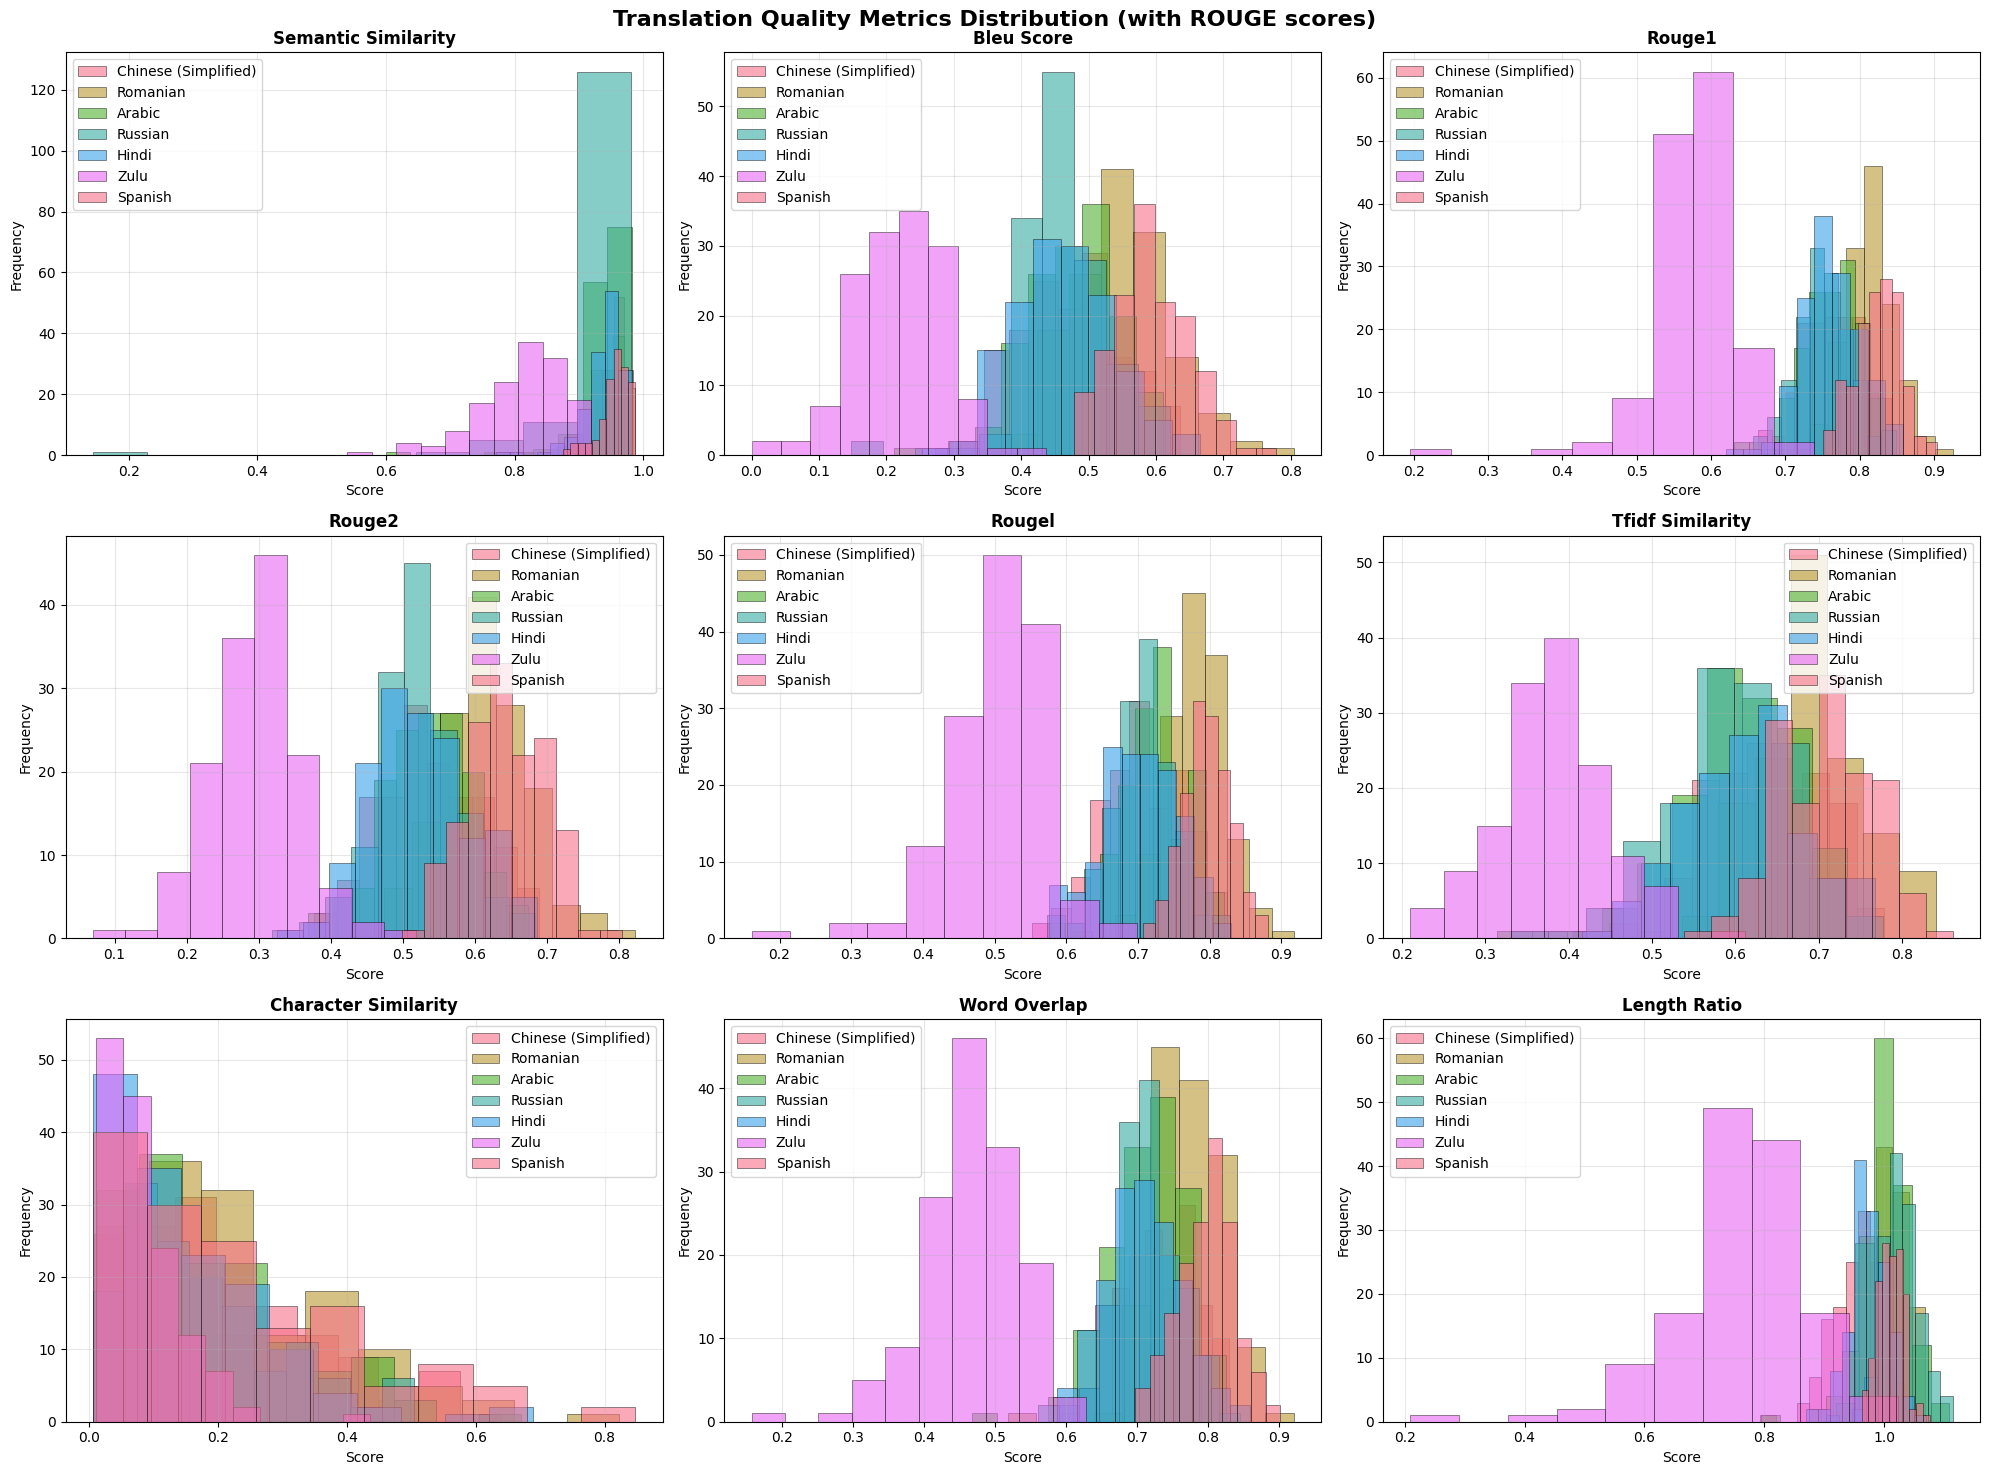

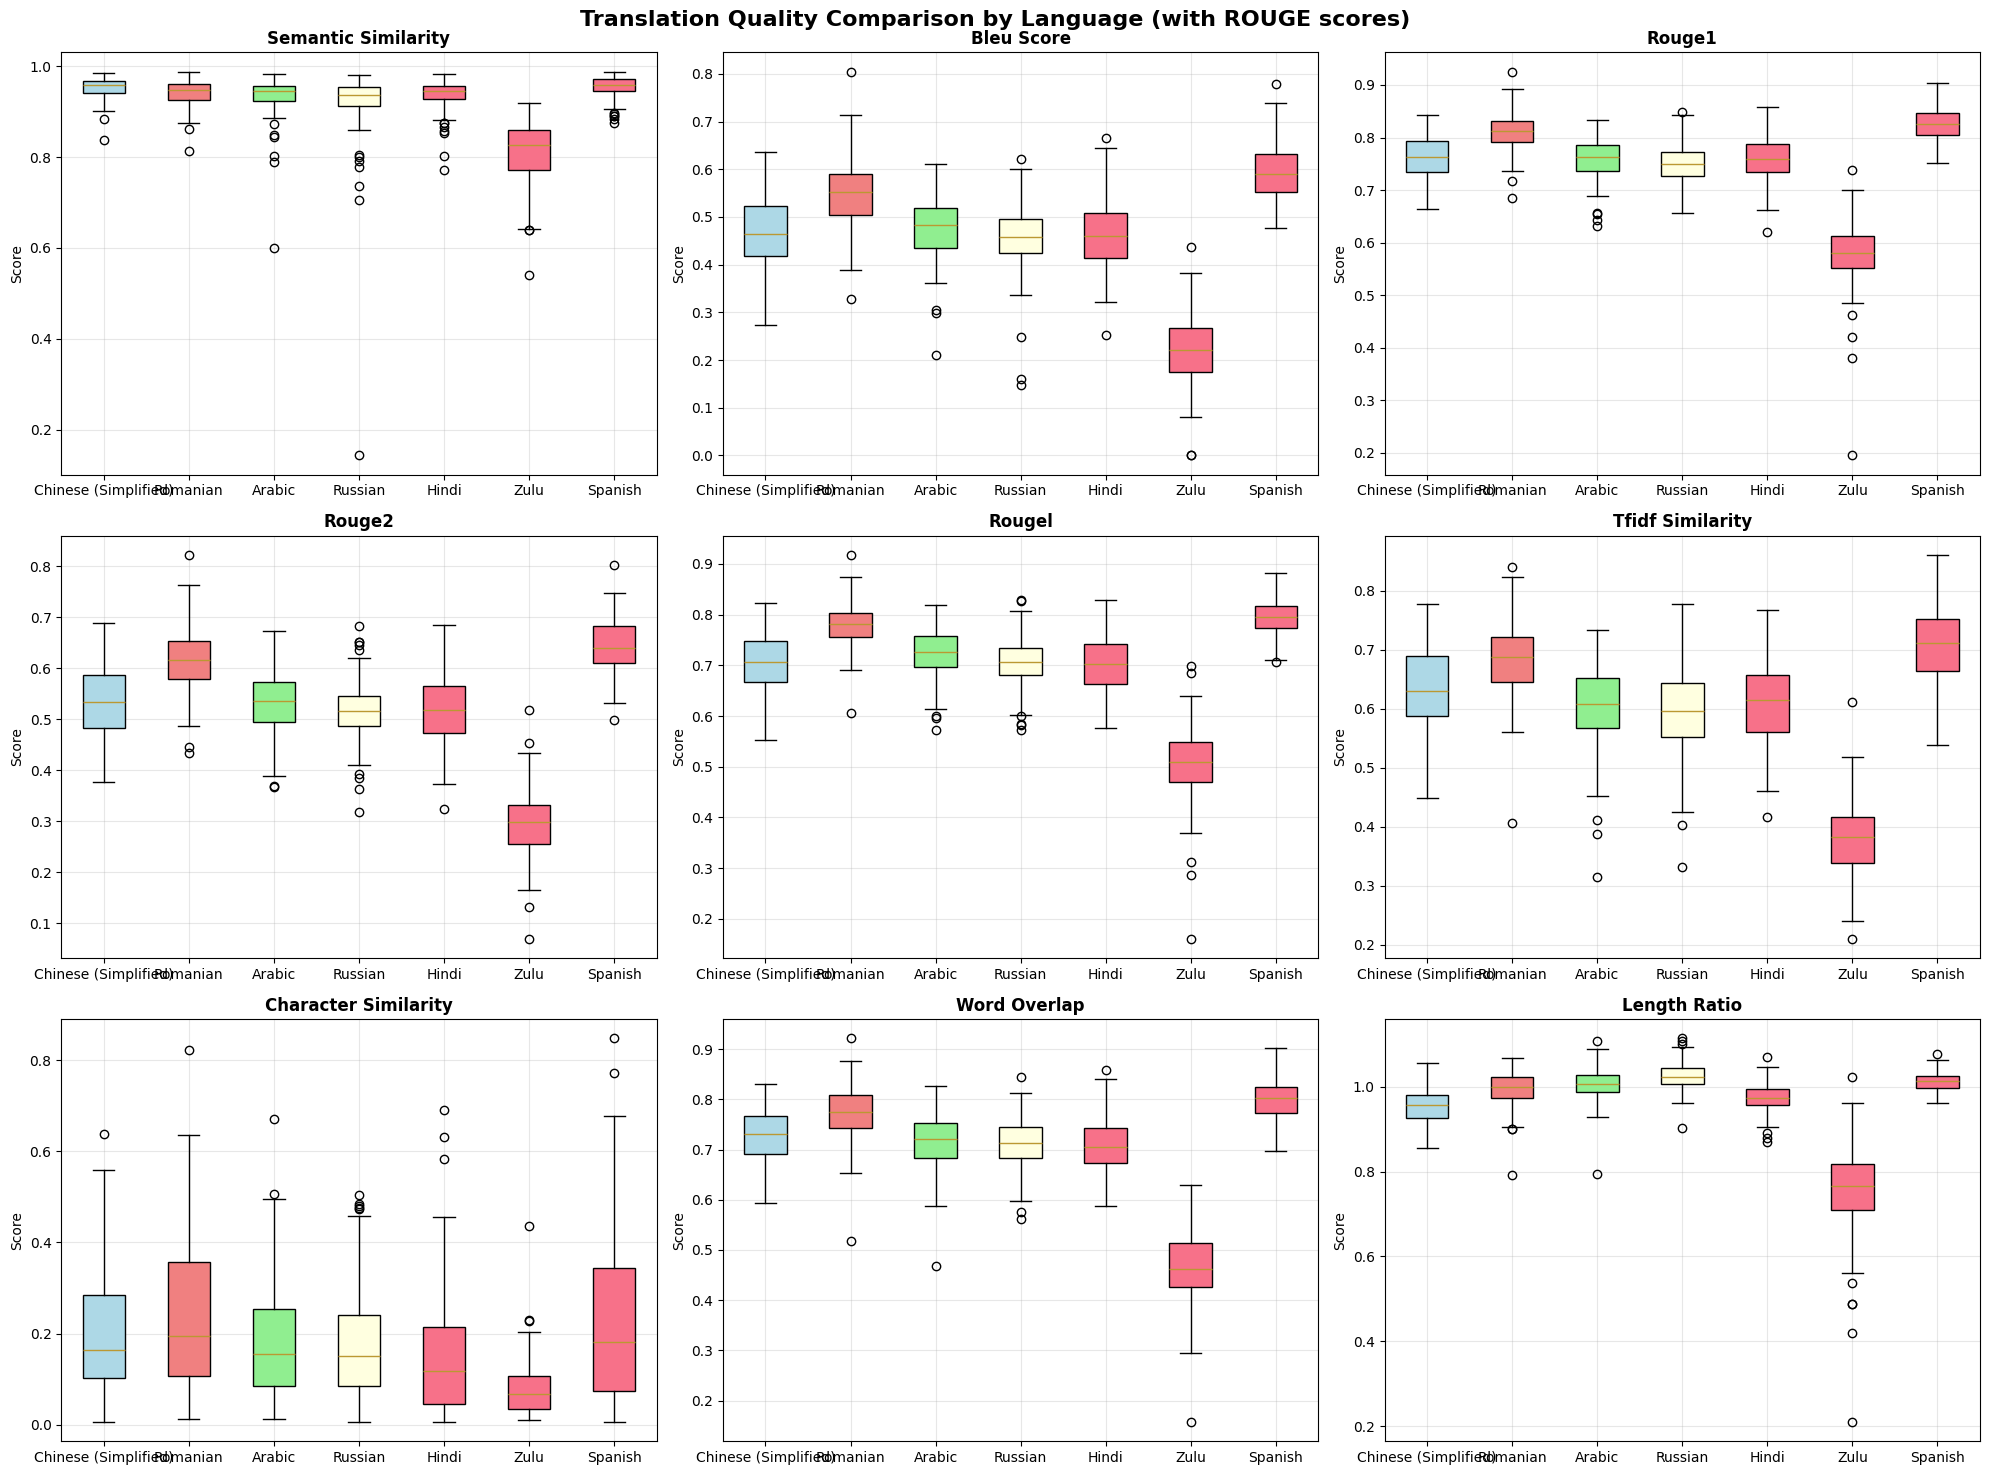


🔥 Creating enhanced correlation heatmap with ROUGE metrics...


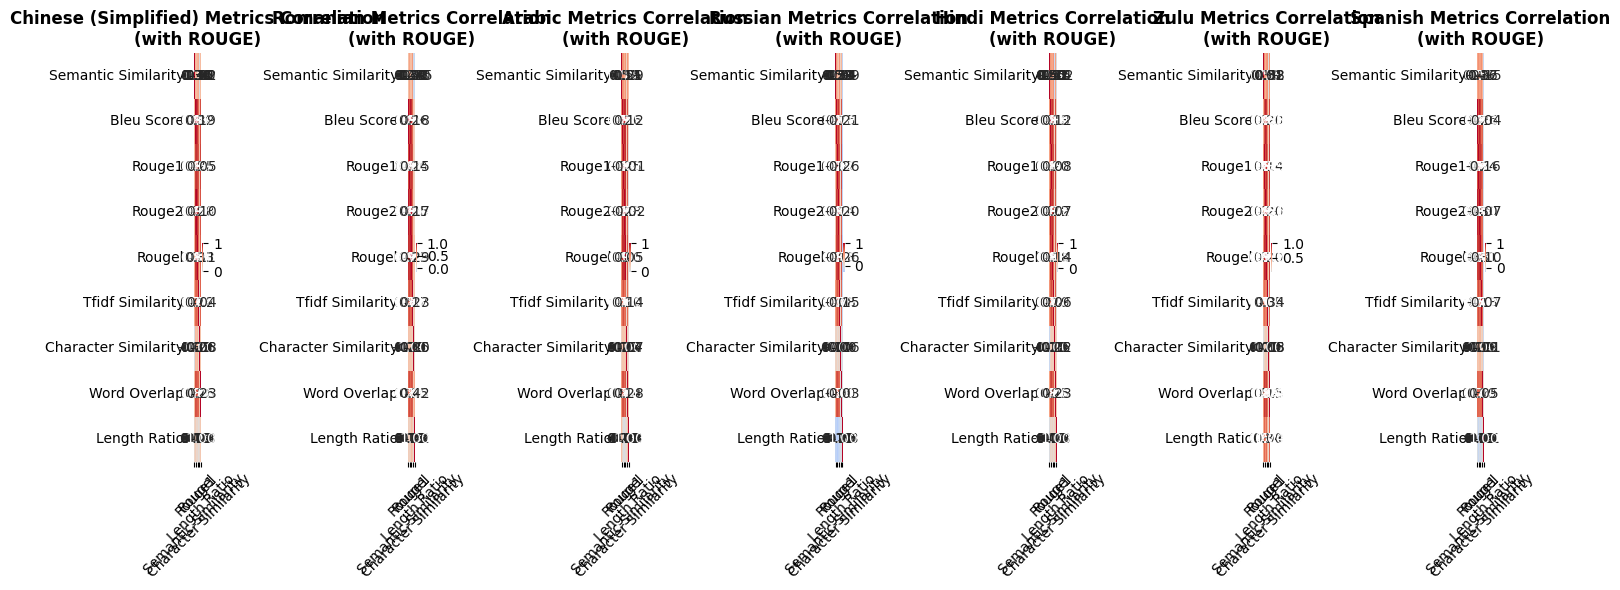


🔍 Creating multi-metric comparison (Semantic vs BLEU vs ROUGE-L)...


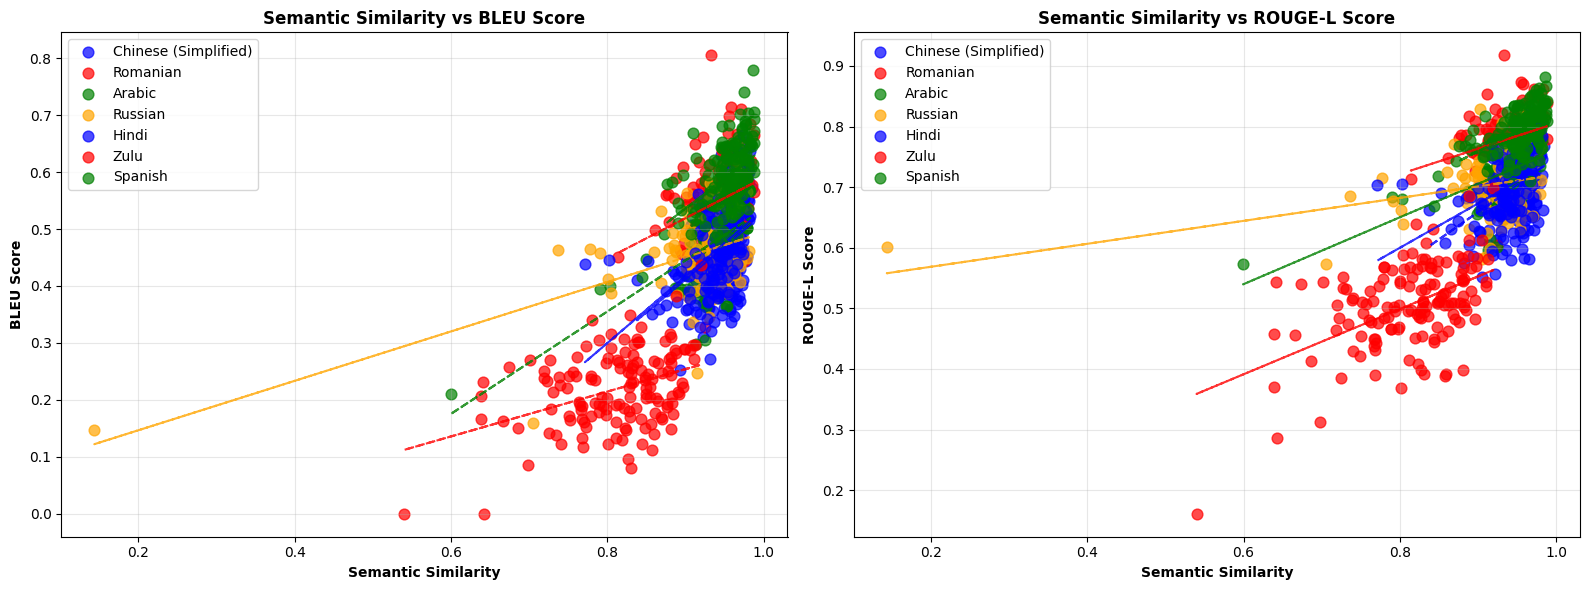


🎯 Creating ROUGE metrics detailed comparison...


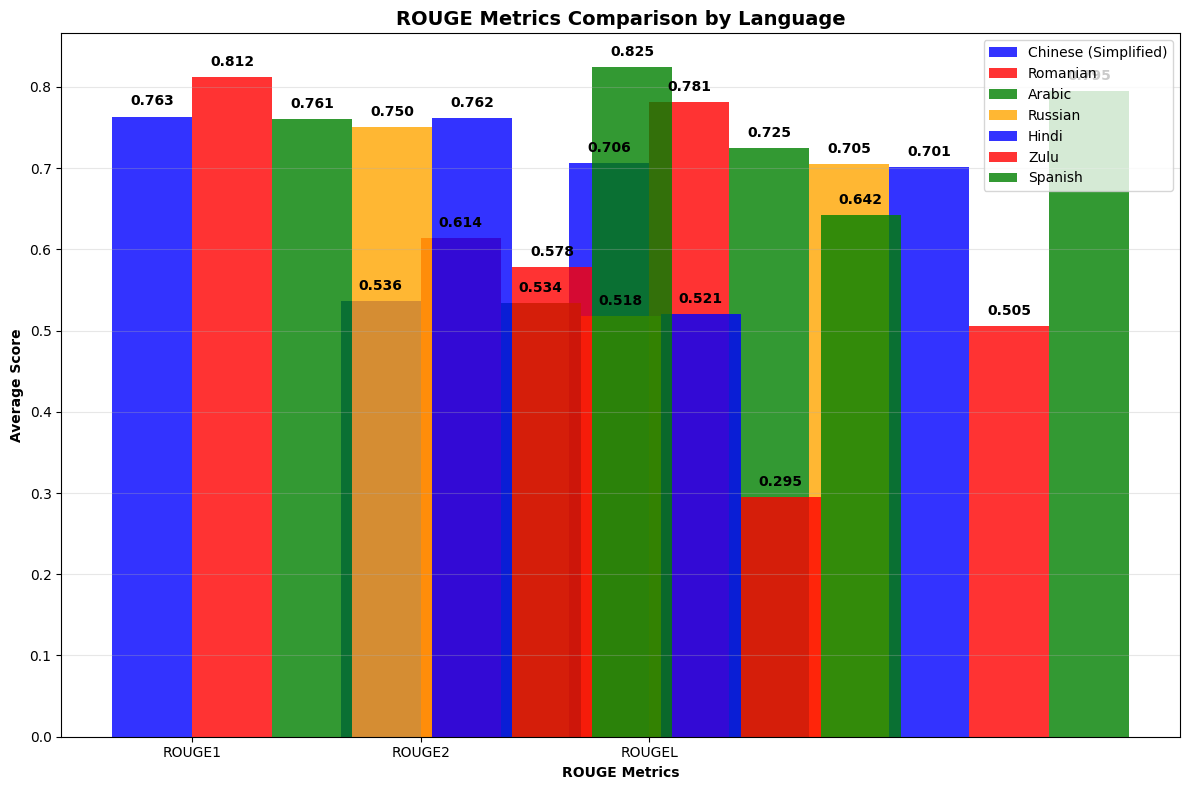


📋 Creating enhanced rights-based analysis...


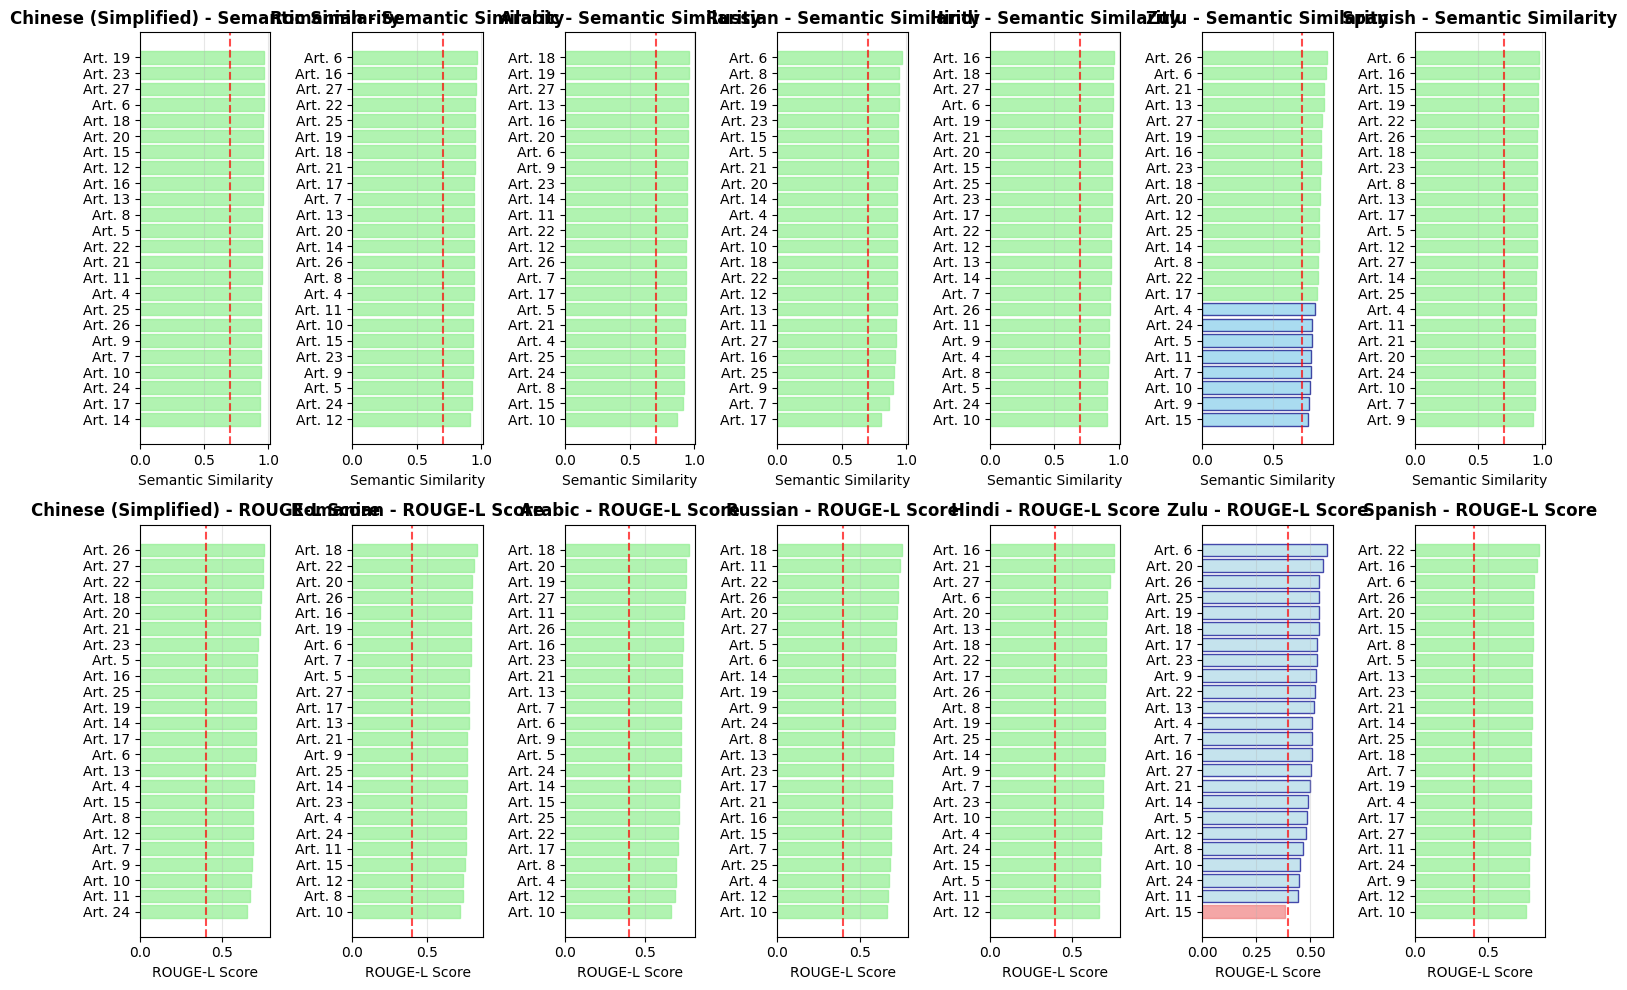


🎯 Creating enhanced examples with all metrics...

🏆 Chinese (Simplified) - Best Translation Examples:

Example 1 - Article 27 (Right to Partake in Cultural Life)
Metrics: SEMANTIC_SIMILARITY: 0.984 | BLEU_SCORE: 0.572 | ROUGE1: 0.804 | ROUGE2: 0.625 | ROUGEL: 0.768
Original:      The government introduces a sweeping policy that prohibits people from attending public concerts, art exhibitions, museums, and scientific lectures, as well as from publishing or publicly displaying their own creative works, citing the need to protect the safety and well-being of children from exposure to content deemed potentially harmful or inappropriate. Under this policy, venues and publishers are required to verify the identity of all participants and contributors, denying access or publication opportunities to people regardless of the content or context of their work. The government justifies this measure by emphasizing its responsibility to uphold the right of children to a safe environment, arguing th

In [8]:
# Create comprehensive visualizations (enhanced with Hugging Face metrics)
print("📊 Creating Enhanced Translation Quality Visualizations")
print("=" * 55)

# Set up the plotting style
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# 1. Distribution of similarity scores (including ROUGE)
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
fig.suptitle('Translation Quality Metrics Distribution (with ROUGE scores)', fontsize=16, fontweight='bold')

metrics_to_plot = ['semantic_similarity', 'bleu_score', 'rouge1', 'rouge2', 'rougeL',
                   'tfidf_similarity', 'character_similarity', 'word_overlap', 'length_ratio']

for i, metric in enumerate(metrics_to_plot):
    row = i // 3
    col = i % 3
    ax = axes[row, col]

    for lang_code, lang_name in TARGET_LANGUAGES.items():
        col_name = f'{lang_code}_{metric}'
        if col_name in similarity_df.columns:
            data = similarity_df[col_name].dropna()
            ax.hist(data, alpha=0.6, label=lang_name, bins=10, edgecolor='black', linewidth=0.5)

    ax.set_title(f'{metric.replace("_", " ").title()}', fontweight='bold')
    ax.set_xlabel('Score')
    ax.set_ylabel('Frequency')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2. Box plots comparing languages (including ROUGE)
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
fig.suptitle('Translation Quality Comparison by Language (with ROUGE scores)', fontsize=16, fontweight='bold')

for i, metric in enumerate(metrics_to_plot):
    row = i // 3
    col = i % 3
    ax = axes[row, col]

    data_for_boxplot = []
    labels = []

    for lang_code, lang_name in TARGET_LANGUAGES.items():
        col_name = f'{lang_code}_{metric}'
        if col_name in similarity_df.columns:
            data_for_boxplot.append(similarity_df[col_name].dropna())
            labels.append(lang_name)

    if data_for_boxplot:
        bp = ax.boxplot(data_for_boxplot, labels=labels, patch_artist=True)

        # Color the boxes
        colors = ['lightblue', 'lightcoral', 'lightgreen', 'lightyellow']
        for patch, color in zip(bp['boxes'], colors[:len(bp['boxes'])]):
            patch.set_facecolor(color)

    ax.set_title(f'{metric.replace("_", " ").title()}', fontweight='bold')
    ax.set_ylabel('Score')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3. Correlation heatmap between metrics (including ROUGE)
print("\n🔥 Creating enhanced correlation heatmap with ROUGE metrics...")

# Prepare correlation data
correlation_data = {}
for lang_code, lang_name in TARGET_LANGUAGES.items():
    lang_columns = [f'{lang_code}_{metric}' for metric in metrics_to_plot
                   if f'{lang_code}_{metric}' in similarity_df.columns]
    if lang_columns:
        correlation_data[lang_name] = similarity_df[lang_columns].corr()

# Create correlation plots
fig, axes = plt.subplots(1, len(TARGET_LANGUAGES), figsize=(15, 6))
if len(TARGET_LANGUAGES) == 1:
    axes = [axes]

for i, (lang_name, corr_matrix) in enumerate(correlation_data.items()):
    # Clean up column names for display
    clean_columns = [col.split('_', 1)[1].replace('_', ' ').title() for col in corr_matrix.columns]
    corr_matrix_clean = corr_matrix.copy()
    corr_matrix_clean.columns = clean_columns
    corr_matrix_clean.index = clean_columns

    sns.heatmap(corr_matrix_clean, annot=True, cmap='coolwarm', center=0,
                ax=axes[i], cbar_kws={'shrink': 0.8}, fmt='.2f')
    axes[i].set_title(f'{lang_name} Metrics Correlation\n(with ROUGE)', fontweight='bold')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.show()

# 4. Multi-metric comparison: Semantic vs BLEU vs ROUGE-L
print("\n🔍 Creating multi-metric comparison (Semantic vs BLEU vs ROUGE-L)...")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Semantic vs BLEU
colors = ['blue', 'red', 'green', 'orange']
for i, (lang_code, lang_name) in enumerate(TARGET_LANGUAGES.items()):
    semantic_col = f'{lang_code}_semantic_similarity'
    bleu_col = f'{lang_code}_bleu_score'

    if semantic_col in similarity_df.columns and bleu_col in similarity_df.columns:
        x = similarity_df[semantic_col]
        y = similarity_df[bleu_col]

        axes[0].scatter(x, y, alpha=0.7, label=lang_name, s=60, color=colors[i % len(colors)])

        # Add trend line
        z = np.polyfit(x.dropna(), y.dropna(), 1)
        p = np.poly1d(z)
        axes[0].plot(x, p(x), linestyle='--', color=colors[i % len(colors)], alpha=0.8)

axes[0].set_xlabel('Semantic Similarity', fontweight='bold')
axes[0].set_ylabel('BLEU Score', fontweight='bold')
axes[0].set_title('Semantic Similarity vs BLEU Score', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Semantic vs ROUGE-L
for i, (lang_code, lang_name) in enumerate(TARGET_LANGUAGES.items()):
    semantic_col = f'{lang_code}_semantic_similarity'
    rougeL_col = f'{lang_code}_rougeL'

    if semantic_col in similarity_df.columns and rougeL_col in similarity_df.columns:
        x = similarity_df[semantic_col]
        y = similarity_df[rougeL_col]

        axes[1].scatter(x, y, alpha=0.7, label=lang_name, s=60, color=colors[i % len(colors)])

        # Add trend line
        z = np.polyfit(x.dropna(), y.dropna(), 1)
        p = np.poly1d(z)
        axes[1].plot(x, p(x), linestyle='--', color=colors[i % len(colors)], alpha=0.8)

axes[1].set_xlabel('Semantic Similarity', fontweight='bold')
axes[1].set_ylabel('ROUGE-L Score', fontweight='bold')
axes[1].set_title('Semantic Similarity vs ROUGE-L Score', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 5. ROUGE metrics comparison
print("\n🎯 Creating ROUGE metrics detailed comparison...")

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

rouge_metrics = ['rouge1', 'rouge2', 'rougeL']
x_pos = np.arange(len(rouge_metrics))
width = 0.35

for i, (lang_code, lang_name) in enumerate(TARGET_LANGUAGES.items()):
    rouge_scores = []
    for rouge_metric in rouge_metrics:
        col_name = f'{lang_code}_{rouge_metric}'
        if col_name in similarity_df.columns:
            rouge_scores.append(similarity_df[col_name].mean())
        else:
            rouge_scores.append(0)

    ax.bar(x_pos + i*width, rouge_scores, width,
           label=lang_name, alpha=0.8, color=colors[i % len(colors)])

ax.set_xlabel('ROUGE Metrics', fontweight='bold')
ax.set_ylabel('Average Score', fontweight='bold')
ax.set_title('ROUGE Metrics Comparison by Language', fontweight='bold', fontsize=14)
ax.set_xticks(x_pos + width/2)
ax.set_xticklabels([metric.upper() for metric in rouge_metrics])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (lang_code, lang_name) in enumerate(TARGET_LANGUAGES.items()):
    for j, rouge_metric in enumerate(rouge_metrics):
        col_name = f'{lang_code}_{rouge_metric}'
        if col_name in similarity_df.columns:
            score = similarity_df[col_name].mean()
            ax.text(j + i*width, score + 0.01, f'{score:.3f}',
                   ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# 6. Rights-based analysis visualization (updated)
print("\n📋 Creating enhanced rights-based analysis...")

if 'limited_article' in similarity_df.columns:
    # Compare semantic similarity and ROUGE-L by article
    fig, axes = plt.subplots(2, len(TARGET_LANGUAGES), figsize=(15, 10))
    if len(TARGET_LANGUAGES) == 1:
        axes = axes.reshape(-1, 1)

    for i, (lang_code, lang_name) in enumerate(TARGET_LANGUAGES.items()):
        # Semantic similarity by article
        semantic_col = f'{lang_code}_semantic_similarity'
        if semantic_col in similarity_df.columns:
            article_means = similarity_df.groupby('limited_article')[semantic_col].mean().sort_values(ascending=True)

            bars = axes[0, i].barh(range(len(article_means)), article_means.values,
                                  color='skyblue', edgecolor='navy', alpha=0.7)

            # Color bars based on performance
            for j, bar in enumerate(bars):
                if article_means.values[j] < 0.7:
                    bar.set_color('lightcoral')
                elif article_means.values[j] > 0.8:
                    bar.set_color('lightgreen')

            axes[0, i].set_yticks(range(len(article_means)))
            axes[0, i].set_yticklabels([f'Art. {int(art)}' for art in article_means.index])
            axes[0, i].set_xlabel('Semantic Similarity')
            axes[0, i].set_title(f'{lang_name} - Semantic Similarity', fontweight='bold')
            axes[0, i].grid(True, alpha=0.3, axis='x')
            axes[0, i].axvline(x=0.7, color='red', linestyle='--', alpha=0.7)

        # ROUGE-L by article
        rougeL_col = f'{lang_code}_rougeL'
        if rougeL_col in similarity_df.columns:
            article_rouge = similarity_df.groupby('limited_article')[rougeL_col].mean().sort_values(ascending=True)

            bars = axes[1, i].barh(range(len(article_rouge)), article_rouge.values,
                                  color='lightblue', edgecolor='darkblue', alpha=0.7)

            # Color bars based on performance
            for j, bar in enumerate(bars):
                if article_rouge.values[j] < 0.4:
                    bar.set_color('lightcoral')
                elif article_rouge.values[j] > 0.6:
                    bar.set_color('lightgreen')

            axes[1, i].set_yticks(range(len(article_rouge)))
            axes[1, i].set_yticklabels([f'Art. {int(art)}' for art in article_rouge.index])
            axes[1, i].set_xlabel('ROUGE-L Score')
            axes[1, i].set_title(f'{lang_name} - ROUGE-L Score', fontweight='bold')
            axes[1, i].grid(True, alpha=0.3, axis='x')
            axes[1, i].axvline(x=0.4, color='red', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

# 7. Enhanced examples of best and worst translations
print("\n🎯 Creating enhanced examples with all metrics...")

def create_enhanced_translation_examples(similarity_df, translation_df, lang_code, lang_name, n_examples=2):
    """Create examples of best and worst translations with all metrics."""
    semantic_col = f'{lang_code}_semantic_similarity'

    if semantic_col not in similarity_df.columns:
        return

    # Get best and worst examples
    best_indices = similarity_df.nlargest(n_examples, semantic_col)['index'].values
    worst_indices = similarity_df.nsmallest(n_examples, semantic_col)['index'].values

    print(f"\n🏆 {lang_name} - Best Translation Examples:")
    for i, idx in enumerate(best_indices):
        row = similarity_df[similarity_df['index'] == idx].iloc[0]
        original_text = translation_df.iloc[idx]['original_text']
        back_translated = translation_df.iloc[idx][f'{lang_code}_back_translation']
        intermediate = translation_df.iloc[idx][f'{lang_code}_intermediate']

        print(f"\nExample {i+1} - Article {row['limited_article']} ({row['limited_article_name']})")

        # Show all available metrics
        available_metrics = ['semantic_similarity', 'bleu_score', 'rouge1', 'rouge2', 'rougeL']
        metric_scores = []
        for metric in available_metrics:
            col_name = f'{lang_code}_{metric}'
            if col_name in similarity_df.columns:
                score = row[col_name]
                metric_scores.append(f"{metric.upper()}: {score:.3f}")

        print(f"Metrics: {' | '.join(metric_scores)}")
        print(f"Original:      {original_text[:]}")
        print(f"{lang_name}:       {intermediate[:]}")
        print(f"Back-trans:    {back_translated[:]}")

    print(f"\n🚨 {lang_name} - Problematic Translation Examples:")
    for i, idx in enumerate(worst_indices):
        row = similarity_df[similarity_df['index'] == idx].iloc[0]
        original_text = translation_df.iloc[idx]['original_text']
        back_translated = translation_df.iloc[idx][f'{lang_code}_back_translation']
        intermediate = translation_df.iloc[idx][f'{lang_code}_intermediate']

        print(f"\nExample {i+1} - Article {row['limited_article']} ({row['limited_article_name']})")

        # Show all available metrics
        available_metrics = ['semantic_similarity', 'bleu_score', 'rouge1', 'rouge2', 'rougeL']
        metric_scores = []
        for metric in available_metrics:
            col_name = f'{lang_code}_{metric}'
            if col_name in similarity_df.columns:
                score = row[col_name]
                metric_scores.append(f"{metric.upper()}: {score:.3f}")

        print(f"Metrics: {' | '.join(metric_scores)}")
        print(f"Original:      {original_text[:]}")
        print(f"{lang_name}:       {intermediate[:]}")
        print(f"Back-trans:    {back_translated[:]}")

# Show enhanced examples for each language
for lang_code, lang_name in TARGET_LANGUAGES.items():
    create_enhanced_translation_examples(similarity_df, translation_df, lang_code, lang_name)

print(f"\n✅ All enhanced visualizations completed!")
print(f"🎉 Enhanced translation quality analysis finished with Hugging Face metrics!")

# Enhanced summary statistics
print(f"\n📊 Enhanced Final Summary (All Scenarios):")
print(f"   • Analyzed {len(similarity_df)} scenarios (complete dataset)")
print(f"   • Tested {len(TARGET_LANGUAGES)} languages: {', '.join(TARGET_LANGUAGES.values())}")

# Count available metrics
available_metrics = set()
for col in similarity_df.columns:
    for lang_code in TARGET_LANGUAGES.keys():
        if col.startswith(f'{lang_code}_'):
            metric_name = col.replace(f'{lang_code}_', '')
            available_metrics.add(metric_name)

print(f"   • Calculated {len(available_metrics)} metrics: {', '.join(sorted(available_metrics))}")

for lang_code, lang_name in TARGET_LANGUAGES.items():
    semantic_col = f'{lang_code}_semantic_similarity'
    bleu_col = f'{lang_code}_bleu_score'
    rouge1_col = f'{lang_code}_rouge1'

    if semantic_col in similarity_df.columns:
        avg_similarity = similarity_df[semantic_col].mean()
        min_similarity = similarity_df[semantic_col].min()
        problematic_count = (similarity_df[semantic_col] < 0.7).sum()

        summary_parts = [f"Semantic: {avg_similarity:.3f} (min: {min_similarity:.3f})"]

        if bleu_col in similarity_df.columns:
            avg_bleu = similarity_df[bleu_col].mean()
            summary_parts.append(f"BLEU: {avg_bleu:.3f}")

        if rouge1_col in similarity_df.columns:
            avg_rouge1 = similarity_df[rouge1_col].mean()
            summary_parts.append(f"ROUGE-1: {avg_rouge1:.3f} (min: {similarity_df[rouge1_col].min():.3f})")

        print(f"   • {lang_name}: {' | '.join(summary_parts)} | {problematic_count} below threshold")